In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml


# load the dataset
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
X.shape

(70000, 784)

In [6]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [7]:
y.shape

(70000,)

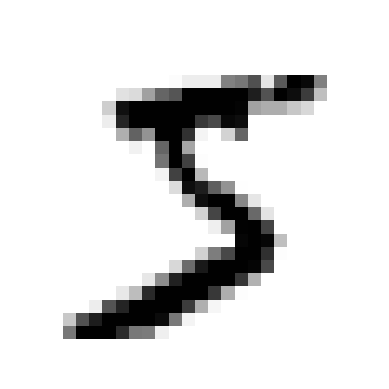

In [8]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

In [10]:
# The dataset is already split into a training set(first 60,000) and shuffled.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [11]:
# Classifier to only detect 5

y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [12]:
from sklearn.linear_model import SGDClassifier


sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# Evaluation

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

# Accuracy can be misleading, the dummy model only predicts False

False


In [16]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

# Confusion Matrices

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

# Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score

# 3530 / (687 + 3530)
# 687 is the false positives, 3530 is the true positives
# measures accuracy. Most important in spam email filters. It is better to only detect true spam emails, even if 
# some spam emails get through
precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [20]:
# 3530 / (1891 + 3530)
# 1891 is the false negatives, 3530 is the true positives
# measures how well the classifier can identify all positive instances. Most important in medical diagnosis, even if 
# more negative cases are identified as positive.
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [22]:
sgd_clf.decision_function([some_digit])


array([2164.22030239])

In [23]:
# get raw descision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve

# get precision and recall scores for all scores
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

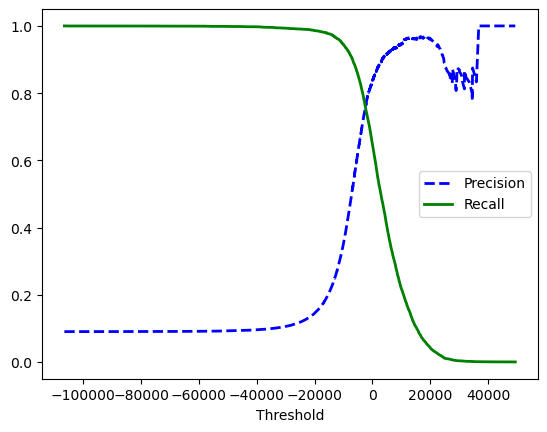

In [25]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()


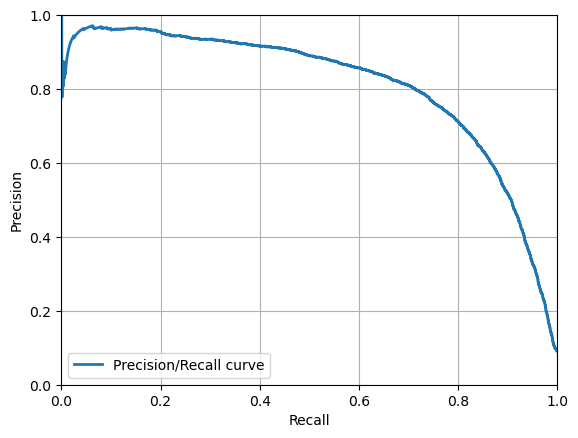

In [26]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

In [27]:
# find the lowest threshold (higher recall) for 90% precision
index_90_precision = (precisions >= 0.9).argmax()
threshold_90_precision = thresholds[index_90_precision]
threshold_90_precision

3370.0194991439557

In [28]:
# test the threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_90_precision

0.4799852425751706

# The ROC Curve

In [31]:
from sklearn.metrics import roc_curve

# get the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [32]:
# find the threshold at which the model achieves 90% precision. <= is used because the thresholds is in descending 
# order
idx_for_threshold_at_90 = (thresholds <= threshold_90_precision).argmax()

# get the true positive rate and false positive rate
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

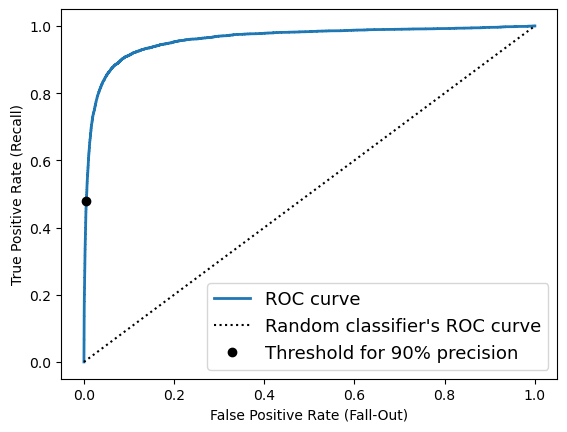

In [33]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.legend(loc="lower right", fontsize=13)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')

plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

# measures the area under the curve
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Create a Random Forest Classifier to compare to the SGD Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [36]:
# get the probabilities for all instances
y_prob_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [37]:
y_prob_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [38]:
# get the second column of probabilities and compute the precision and recall for each threshold
y_scores_forest = y_prob_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

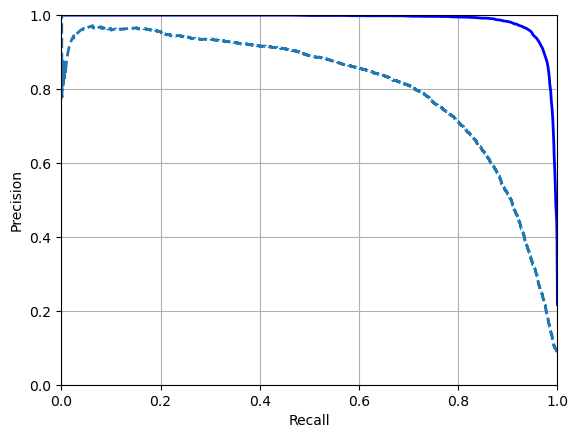

In [39]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
        label="Random Forest")

plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.show()

In [40]:
#get predictions
y_train_pred_forest = y_prob_forest[:, 1] >= 0.5

f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [41]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [42]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [43]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

# Multiclass Classification

In [44]:
from sklearn.svm import SVC

# train the first 2000 because SVMs so not scale well to large datasets
# the model will use the one versus one (ovo) strategy to classify
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

In [45]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [46]:
# Show the number of won duels for each class
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [47]:
class_index = some_digit_scores.argmax()

In [48]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [49]:
svm_clf.classes_[class_index]

'5'

Training an sgd classifier

In [50]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [51]:
# The prediction is wrong, lets see its confidence scores
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

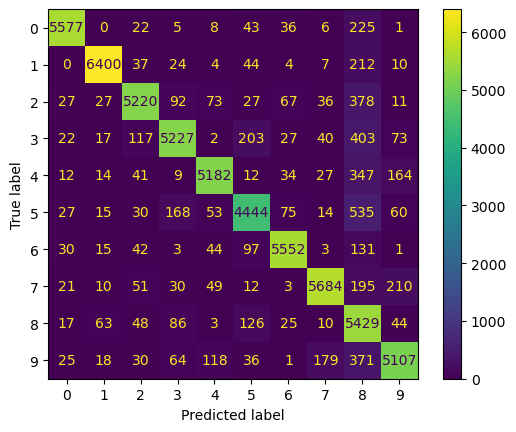

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

It's important to normalize the confusion matrix in case some numbers are more common in the dataset.

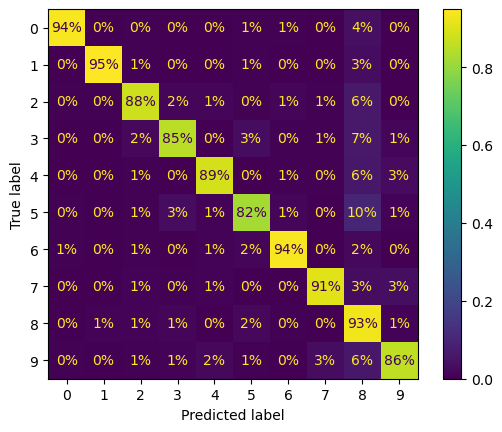

In [55]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

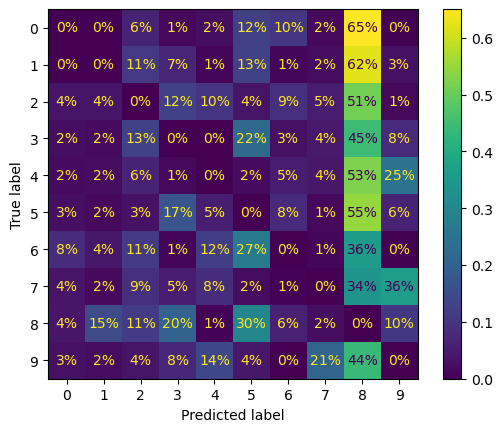

In [56]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()